### Import Packages

In [90]:
import numpy as np
import pandas as pd
import json
import requests
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import datetime
import folium
from folium import plugins
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates

from pandas.io.json import json_normalize
%matplotlib inline

### Load 1 Year of Data

In [2]:
# startDate = "2017-01-01"
# datelist = pd.date_range(pd.to_datetime(startDate), periods=366).tolist() #1 year of data

In [3]:
# requestsDataFrame = pd.DataFrame()

# for index in range(len(datelist)-1):
#     day = str(datelist[index].date())
#     nextDay = str(datelist[index+1].date())
#     url = """https://secure.toronto.ca/webwizard/ws/requests.json?start_date=""" + day + """T00:00:00Z&end_date=""" + nextDay + """T00:00:00Z&jurisdiction_id=toronto.ca"""
#     response = requests.get(url)
#     response = json_normalize(response.json()['service_requests'])
#     assert response.shape[0] < 1000
#     requestsDataFrame = pd.concat([requestsDataFrame, response])

In [4]:
# requestsDataFrame.to_pickle("./rawData.pkl")

In [5]:
requestsDataFrame = pd.read_pickle("rawData.pkl")

### Basic data cleaning

In [6]:
requestsDataFrame.reset_index(inplace = True)
requestsDataFrame.drop(['index'], axis = 1, inplace = True)

In [7]:
requestsDataFrame.requested_datetime = pd.to_datetime(requestsDataFrame.requested_datetime)
requestsDataFrame.expected_datetime = pd.to_datetime(requestsDataFrame.expected_datetime)
requestsDataFrame.updated_datetime = pd.to_datetime(requestsDataFrame.updated_datetime)

In [8]:
#remove duplicate service_request_id's -> take latest updated datetime
rows = requestsDataFrame.groupby("service_request_id")['updated_datetime'].transform(max) == requestsDataFrame['updated_datetime']
requestsDataFrame = requestsDataFrame[rows]

In [9]:
columns = ["service_request_id", "lat", "long", "service_name", "requested_datetime", "expected_datetime",
           "updated_datetime", "status", "status_notes"]
requestsDataFrame = requestsDataFrame[columns]
requestsDataFrame = requestsDataFrame.dropna()
requestsDataFrame = requestsDataFrame.drop_duplicates()

### Assertions

In [10]:
#check if no duplicate service_request_id's
assert requestsDataFrame.shape[0] == len(requestsDataFrame['service_request_id'].unique())

In [11]:
# Ensure number of days == 365
assert len(pd.to_datetime(requestsDataFrame.requested_datetime).dt.date.unique()) == 365

### EDA

In [12]:
pd.DataFrame(requestsDataFrame.groupby('service_name')['service_name'].agg(len))

,service_name
service_name,
Bridge - Graffiti Complaint,349
Graffiti,2120
Litter / Bin / Graffiti on Bin,22
Road - Graffiti Complaint,111
Road - Pot hole,11489
Sidewalk - Graffiti Complaint,284


In [13]:
pd.DataFrame(requestsDataFrame.groupby(['service_name', 'status'])['status'].agg(len))

status
service_name                   status        
Bridge - Graffiti Complaint    closed     349
Graffiti                       closed    2088
                               open        32
Litter / Bin / Graffiti on Bin closed      22
Road - Graffiti Complaint      closed     111
Road - Pot hole                closed   11321
                               open       168
Sidewalk - Graffiti Complaint  closed     278
                               open         6

In [14]:
pd.DataFrame(requestsDataFrame.groupby('status_notes')['status_notes'].agg(len))

,status_notes
status_notes,
"Cancelled - The request may be a duplicate, work is previously scheduled or no work is required.",363
Completed - The request has been concluded.,13806
In progress - The request has been scheduled.,30
"In progress - The request is being investigated, assessed and/or responded to; additional work may be required, if applicable.",176


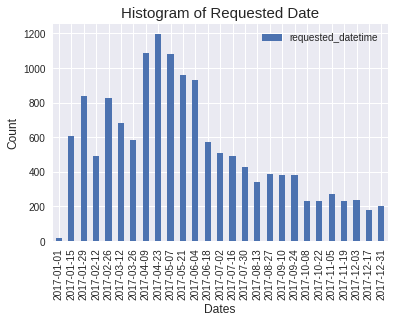

In [132]:
#Histogram of Requested Datetime
histogram_plot(data=requestsDataFrame, column_name="requested_datetime", period="2W",
               plot_title = "Histogram of Requested Date", xaxis_label = "Date", yaxis_label = "Count")

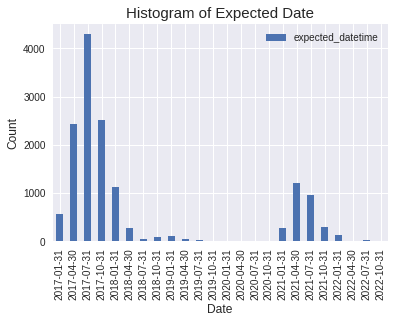

In [169]:
#Histogram of Expected Datetime
histogram_plot(data=requestsDataFrame, column_name="expected_datetime", period="3M",
               plot_title = "Histogram of Expected Date", xaxis_label = "Date", yaxis_label = "Count")

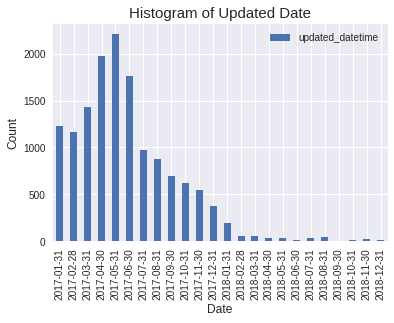

In [133]:
#Histogram of Updated Datetime
histogram_plot(data=requestsDataFrame, column_name="updated_datetime", period="1M",
               plot_title = "Histogram of Updated Date", xaxis_label = "Date", yaxis_label = "Count")

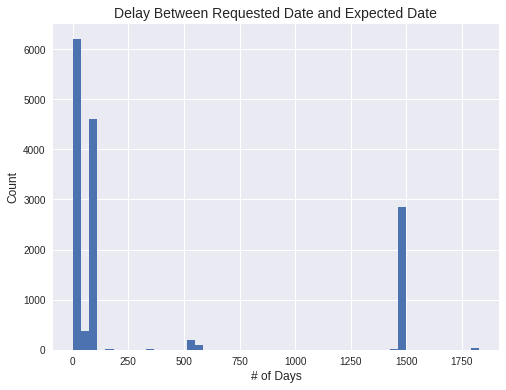

In [180]:
#Count of Time Delay In Days (expected time vs. requestedtime)
requestsDataFrame['TimeDelay'] = requestsDataFrame['expected_datetime']-requestsDataFrame['requested_datetime']
requestsDataFrame['TimeDelay'] = requestsDataFrame['TimeDelay'].dt.days

fig, ax = plt.subplots(figsize=(8, 6))
plt.hist(requestsDataFrame['TimeDelay'].values, bins = 50)
ax.set_title("Delay Between Requested Date and Expected Date", fontsize = 14)
ax.set_xlabel("# of Days", fontsize = 12)
ax.set_ylabel("Count", fontsize = 12)    

In [181]:
#Expected Number of Days To Complete
pd.DataFrame(requestsDataFrame.groupby('service_name')['TimeDelay'].agg("mean"))

,TimeDelay
service_name,
Bridge - Graffiti Complaint,53.000000
Graffiti,7.482547
Litter / Bin / Graffiti on Bin,13.272727
Road - Graffiti Complaint,34.135135
Road - Pot hole,419.353730
Sidewalk - Graffiti Complaint,33.105634


In [182]:
#Expected Number of Days To Complete (Closed Only)
pd.DataFrame(requestsDataFrame[requestsDataFrame["status"] == "closed"].groupby('service_name')['TimeDelay'].agg("mean"))

,TimeDelay
service_name,
Bridge - Graffiti Complaint,53.000000
Graffiti,7.477969
Litter / Bin / Graffiti on Bin,13.272727
Road - Graffiti Complaint,34.135135
Road - Pot hole,409.390602
Sidewalk - Graffiti Complaint,31.866906


In [183]:
#Expected Number of Days To Complete (Open Only)
pd.DataFrame(requestsDataFrame[requestsDataFrame["status"] == "open"].groupby('service_name')['TimeDelay'].agg("mean"))

,TimeDelay
service_name,
Graffiti,7.781250
Road - Pot hole,1090.738095
Sidewalk - Graffiti Complaint,90.500000


In [ ]:
#log and lat and then comapre log/lat to time delay

In [ ]:
#map first point
points = requestsDataFrame[['lat', 'long']].as_matrix()
m = folium.Map([points[:, 0].mean(), points[:, 1].mean()], zoom_start=11)
m.add_child(plugins.HeatMap(points, radius=15))
m

### Helper Functions

In [168]:
def histogram_plot(data, column_name, period, plot_title, xaxis_label, yaxis_label):
    data = pd.DataFrame(requestsDataFrame[column_name])
    data.set_index(column_name, drop=False, inplace=True)
    
    ax = data.groupby(pd.TimeGrouper(freq=period)).count().plot(kind='bar')

    xlabel = []
    for d in ax.get_xticklabels():
        date = datetime.datetime.strptime(d.get_text(), '%Y-%m-%d %H:%M:%S')
        xlabel.append(date.strftime("%Y-%m-%d"))

    ax.set_xticklabels(xlabel)
    
    ax.set_title(plot_title, fontsize = 15)
    ax.set_xlabel(xaxis_label, fontsize = 12)
    ax.set_ylabel(yaxis_label, fontsize = 12)    